# **LLM for Secure Code**

This POC is to check if the LLM models like GPT-3, 3.5 can be used for identifying the potential security vulnerabilities from the code. 

## **Challenge with current code analyzers**

Current code analyzers are
1. Language dependent
2. Require Human / Vendor dependency for adding new vulnerability checks
3. Require multiple code analysis tools to cover all aspects


## **POC Approach**

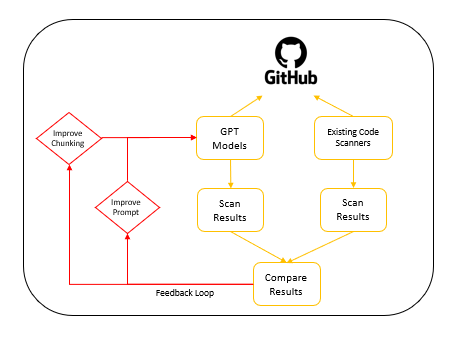

1. The approach was to use available open source GPT models from OpenAI, to scan a given GitHub repository. 
2. The code has few intentional vulnerabilities added in order to check the model performance. 
3. The same code was scanned by other code scanning tools available
4. Vulnerabilities found from both GPT models and Scanning tools were compared to determine performance of model output

**GPT Models used** - GPT-3 (text-davinci-003), GPT-3.5 (gpt-3.5-turbo)

**Code Scanning Tools used** - CodeQL, Snyk Security




In [1]:
# initialization steps
!npx degit https://github.com/poornimadevip/Vulnerable-Code-Snippets code -f
!pip install openai
!pip install tiktoken

import os
import pandas as pd
import openai
import tiktoken
import numpy as np
import platform
import re
import nltk
import time
nltk.download('punkt')
from nltk.tokenize import word_tokenize

npx: installed 1 in 3.166s
> cloned poornimadevip/Vulnerable-Code-Snippets#HEAD to code
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
valid_file_extension = ['.py','.php', '.go', '.js', '.rb', '.ts', '.c', '.cs', '.html', '.java', '.asp', '.cpp','.vb']
def load_files(dir):                                                                                                  
    df = pd.DataFrame()  
    name, content, extension = [], [], []                                                                                                     
    subdirs = [x[0] for x in os.walk(dir)]                                                                            
    for subdir in subdirs:                                                                                            
        files = os.walk(subdir).__next__()[2]                                                                             
        if (len(files) > 0):                                                                                          
            for file in files:        
                file_name = os.path.join(subdir, file)
                _, ext = os.path.splitext(file_name)
                if ext in valid_file_extension:
                    name.append(file_name)
                    extension.append(ext)
                    with open(file_name, "r") as target_file:
                        content.append(target_file.read())
                    
    df['file_name'] = name
    df['ext'] = extension
    df['code'] = content; 
    df['tokens'] = df['code'].str.len()                                                                   
    return df

def get_files_list(dir):
    list = []                                                                                                  
    subdirs = [x[0] for x in os.walk(dir)]                                                                            
    for subdir in subdirs:                                                                                            
        files = os.walk(subdir).__next__()[2]                                                                             
        if (len(files) > 0):                                                                                          
            for file in files:        
                file_name = os.path.join(subdir, file)
                _, ext = os.path.splitext(file_name)
                if ext in valid_file_extension:
                    list.append(file_name)                                                                   
    return list
  
def break_up_text(tokens, chunk_size, overlap_size):
    if len(tokens) <= chunk_size:
        yield tokens
    else:
        chunk = tokens[:chunk_size]
        yield chunk
        yield from break_up_text(tokens[chunk_size-overlap_size:], chunk_size, overlap_size)


def break_up_text_to_chunks(text, chunk_size=700, overlap_size=20):
    tokens = word_tokenize(text)
    return list(break_up_text(tokens, chunk_size, overlap_size))

def convert_to_detokenized_text(tokenized_text):
    detokenized_text = " ".join(tokenized_text)
    detokenized_text = detokenized_text.replace(" 's", "'s")
    return detokenized_text

def get_file_content(file_name):
  with open(file_name, "r") as target_file:
    file_content = target_file.read()
  return file_content

def get_predictions(file_name):
  file_content = get_file_content('code/'+file_name)
  print('file... '+file_name)
  new_file_name = file_name.replace('/','_')
  f = open("findings/"+new_file_name,"w+")
  f.write('Findings from GPT 3 Davinci...\n')
  print('Findings from GPT 3 Davinci...')
  f.write(GPT_Detection_3(baseprompt + file_content))
  f.write('\n********\n')
  f.write('Findings from GPT 3.5 Turbo ...\n')
  print('Findings from GPT 3.5 Turbo ...')
  f.write(GPT_Detection_3_5(baseprompt + file_content))
  f.write('\n********\n')
  f.write('Findings from GPT 3.5 Turbo with improved prompt ...\n')
  print('Findings from GPT 3.5 Turbo with improved prompt ...')
  f.write(GPT_Detection_3_5_withImprovedPrompt(baseprompt + file_content))
  f.write('\n********\n')
  f.write('Findings from GPT 3.5 Turbo with improved prompt and chunked code ...\n')
  print('Findings from GPT 3.5 Turbo with improved prompt and chunked code ...')
  responses = GPT_Detection_3_5_withTokens(file_content)
  for response in responses:
      f.write(response)
      f.write('\n')
  f.write('\n********\n')
  f.close

def get_predictions_updated(file_name):
  file_content = get_file_content(file_name)
  print('file... '+file_name)
  new_file_name = file_name.replace('code/','').replace('/','_')
  f = open("findings/"+new_file_name,"w+")
  f.write('Findings from GPT 3 Davinci with improved prompt and chunked code ...\n')
  print('Findings from GPT 3 Davinci with improved prompt and chunked code ...')
  responses = GPT_Detection_3_withTokens(file_content)
  for response in responses:
      f.write(response)
      f.write('\n')
  f.write('\n********\n')
  f.close

In [4]:
#baseprompt = 'Find out all issues in this code '
#baseprompt = 'Find all the issues in this code and list the CVE, CWE, CVSS number with explanation '
# baseprompt = 'Detect security issues in the code '
# baseprompt = 'Report all the security issues from the below code, in json format, along with the type, description, location, example and the sample fix '
# baseprompt = 'list all the security issues from the below code \
#               and report the list in JSON format, along with the \
#               type, description, location, example and the sample fix '
baseprompt = 'list all the security issues from the below code \
              only in JSON format, along with the \
              type, description in 20 words, line number, example code fix '

def GPT_Detection_3(texts, temp=0.2):
  texts = baseprompt + texts
  if len(texts) > 3000:
    return 'MAX_TOKENS_EXCEEDED'
  response = openai.Completion.create(engine="text-davinci-003",
                                      prompt =  texts,                                    
                                      temperature = temp,
                                      top_p = 1,
                                      max_tokens = 2000,
                                      frequency_penalty = 0,
                                      presence_penalty = 0.5)
  return response.choices[0].text

def GPT_Detection_3_5(texts, temp=0):
  texts = baseprompt + texts
  if len(texts) > 3000:
    return 'MAX_TOKENS_EXCEEDED'
  response = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                               messages=[
                                   {"role": "user", "content":texts}
                               ],
                               temperature=temp,
                               max_tokens = 4000-len(texts),
                               frequency_penalty = 0,
                               presence_penalty = 0
                               )
  return response.choices[0].message.content

def GPT_Detection_3_5_withImprovedPrompt(texts, temp=0):
  texts = baseprompt + texts
  if len(texts) > 3000:
    return 'MAX_TOKENS_EXCEEDED'
  response = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                               messages=[
                                   {"role": "user", "content":texts},
                                   {"role": "user", "content": "Identify any \
                                   security issues in the given code. \
                                   Specify the type of security vulnerability \
                                   first, then provide a 20 words short description of \
                                   the vulnerability identified and then \
                                   provide a concise fix by quoting the code \
                                   to be fixed"},
                                   {"role": "user", "content": "use the following format\
                                   Type: Insecure File Upload\
                                   Description: \
                                   Fix: "}
                               ],
                               temperature=temp,
                               max_tokens = 4000-len(texts),
                               frequency_penalty = 0,
                               presence_penalty = 0
                               )
  return response.choices[0].message.content

def consolidate_summary(texts, temp=0):
  texts = 'Consolidate these summaries by maintaining the same format of Type, Description and fix ' + texts
  response = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                               messages=[
                                   {"role": "user", "content":texts},
                                   {"role": "user", "content": "Consolidate the given text and remove duplicate information, provide the list in the same format"},
                                   {"role": "user", "content": "use the following format for each finding\
                                   Type: Insecure File Upload\
                                   Description: \
                                   Fix: "}
                               ],
                               temperature=temp,
                               max_tokens = 4000-len(texts),
                               frequency_penalty = 0,
                               presence_penalty = 0
                               )
  
  return response.choices[0].message.content

def consolidate_summary_3(texts, temp=0):
  texts = 'Combine the json objects into one unique list based on line number' + texts
  response = openai.Completion.create(engine="text-davinci-003",
                                      prompt =  texts,                                    
                                      temperature = temp,
                                      top_p = 1,
                                      max_tokens = 3000,
                                      frequency_penalty = 0,
                                      presence_penalty = 0)
  return response.choices[0].text

def GPT_Detection_3_5_withTokens(texts, temp=0):
    responses = []
    chunks = break_up_text_to_chunks(texts)
    for i, chunk in enumerate(chunks):
      prompt = convert_to_detokenized_text(chunk)
      response = GPT_Detection_3_5_withImprovedPrompt(baseprompt+prompt, temp)
      responses.append(response)

    # return consolidate_summary(str(responses))
    return responses

def GPT_Detection_3_withTokens(texts, temp=0):
    responses = []
    chunks = break_up_text_to_chunks(texts, 300, 50)
    for i, chunk in enumerate(chunks):
      prompt = convert_to_detokenized_text(chunk)
      response = GPT_Detection_3(baseprompt+prompt, 0.2)
      responses.append(response)

    return consolidate_summary_3(str(responses))
    #return responses

In [ ]:
# file_list = get_files_list("code")
# print(file_list)

['code/CVE-2015-8562.php', 'code/Buffer Overflow/gets.c', 'code/Buffer Overflow/sprintf.c', 'code/Buffer Overflow/netkit-telnet 0.17.c', 'code/Buffer Overflow/example1.c', 'code/Buffer Overflow/strcpy.c', 'code/Buffer Overflow/example2.c', 'code/Buffer Overflow/bof1.c', 'code/SQL Injection/example1.rb', 'code/SQL Injection/sql.js', 'code/SQL Injection/example2.js', 'code/SQL Injection/SQLi.cs', 'code/SQL Injection/sqli.php', 'code/SQL Injection/blindsqli.php', 'code/SQL Injection/example.java', 'code/SQL Injection/mysql.js', 'code/Format String Attacks/vuln.c', 'code/Format String Attacks/FormatString.c', 'code/Insecure File Uploads/example3.php', 'code/Insecure File Uploads/example2.php', 'code/Insecure File Uploads/example1.php', 'code/Insecure File Uploads/WishList.php', 'code/Insecure File Uploads/Insomnihack_2019_l33t-hoster.php', 'code/Code Injection/example1.rb', 'code/Code Injection/eval.php', 'code/Code Injection/eval2.php', 'code/LDAP Injection/example2.asp', 'code/LDAP Injec

In [ ]:
# file_list = ['code/CVE-2015-8562.php', 'code/Buffer Overflow/gets.c', 'code/Buffer Overflow/sprintf.c', 'code/Buffer Overflow/netkit-telnet 0.17.c', 'code/Buffer Overflow/example1.c', 'code/Buffer Overflow/strcpy.c', 'code/Buffer Overflow/example2.c', 'code/Buffer Overflow/bof1.c', 'code/SQL Injection/example1.rb', 'code/SQL Injection/sql.js', 'code/SQL Injection/example2.js', 'code/SQL Injection/SQLi.cs', 'code/SQL Injection/sqli.php', 'code/SQL Injection/blindsqli.php', 'code/SQL Injection/example.java', 'code/SQL Injection/mysql.js', 'code/Format String Attacks/vuln.c', 'code/Format String Attacks/FormatString.c', 'code/Insecure File Uploads/example3.php', 'code/Insecure File Uploads/example2.php', 'code/Insecure File Uploads/example1.php', 'code/Insecure File Uploads/WishList.php', 'code/Insecure File Uploads/Insomnihack_2019_l33t-hoster.php', 'code/Code Injection/example1.rb', 'code/Code Injection/eval.php', 'code/Code Injection/eval2.php', 'code/LDAP Injection/example2.asp', 'code/LDAP Injection/example1.php', 'code/LDAP Injection/LDAP.cs', 'code/Sensitive Data Exposure/hardcoded.ts', 'code/Sensitive Data Exposure/Railsgoatconfig.rb', 'code/Sensitive Data Exposure/graphql.ts', 'code/NoSQL Injection/mongodb.js', 'code/Out of Bounds/damnvuln.c', 'code/Server Side Template Injection/asis_ssti_pt.py', 'code/Server Side Template Injection/sstigolang.go', 'code/Server Side Template Injection/test.py', 'code/Server Side Template Injection/Twig.php', 'code/Resource Injection/example1.asp', 'code/Unsafe Deserialization/unsafe.js', 'code/Unsafe Deserialization/pickle2.py', 'code/Unsafe Deserialization/de.js', 'code/Unsafe Deserialization/unserialize.php', 'code/Unsafe Deserialization/CVE-2017-2809.py', 'code/Unsafe Deserialization/java/SerializeToFile.java', 'code/Unsafe Deserialization/java/LogFile.java', 'code/XXE/xxe.js', 'code/XXE/XmlReader_Tests.cs', 'code/XXE/xxe1.cs', 'code/XXE/test2.php', 'code/XXE/test.php', 'code/Path Traversal/example1.java', 'code/Path Traversal/PT1.cs', 'code/Path Traversal/phpexample.php', 'code/Path Traversal/ZipTraversal.java', 'code/Path Traversal/example2.php', 'code/Path Traversal/example3.java', 'code/Path Traversal/PT3.cs', 'code/Path Traversal/ZipTraversalPatched.java', 'code/Path Traversal/PT4.cs', 'code/Path Traversal/gq.js', 'code/Path Traversal/expresstest.js', 'code/Path Traversal/py_ctf.py', 'code/Path Traversal/bypass.php', 'code/Path Traversal/PT2.cs', 'code/Command Injection/CVE-2019-16662.php', 'code/Command Injection/tainted.py', 'code/Command Injection/Cryptolog.php', 'code/Command Injection/cmd1.php', 'code/Command Injection/exec.js', 'code/Command Injection/OSI.cs', 'code/Command Injection/CVE-2019-16663.php', 'code/Command Injection/cmd6.php', 'code/Command Injection/cmd4.php', 'code/Command Injection/cmd3.php', 'code/Command Injection/cmd5.php', 'code/Command Injection/cmd2.php', 'code/PostMessage Security/challenge3.js', 'code/PostMessage Security/challenge1.js', 'code/PostMessage Security/challenge_2.js', 'code/Use After Free/damnvuln.c', 'code/Log Forging/logf.cs', 'code/ReDoS/redos.js', 'code/Connection String Injection/example3.asp', 'code/Connection String Injection/example1.c', 'code/Connection String Injection/example2.java', 'code/IDOR/example1.php', 'code/XSS/example1.html', 'code/XSS/Spring.java', 'code/XSS/express.js', 'code/XSS/XSS.cs', 'code/XSS/dom.php', 'code/XSS/example.php', 'code/XSS/Cookie Security/sc.cs', 'code/XSS/Cookie Security/sc2.cs', 'code/File Inclusion/lfi11.php', 'code/File Inclusion/lfi7.php', 'code/File Inclusion/lfi4.php', 'code/File Inclusion/lfi10.php', 'code/File Inclusion/lfi3.php', 'code/File Inclusion/lfi9.php', 'code/File Inclusion/lfi1.php', 'code/File Inclusion/lfi5.php', 'code/File Inclusion/lfi14.php', 'code/File Inclusion/lfi13.php', 'code/File Inclusion/lfi12.php', 'code/File Inclusion/lfi6.php', 'code/File Inclusion/lfi2.php', 'code/File Inclusion/lfi8.php', 'code/Zip Traversal/myApp.cs', 'code/java/URLRedirectSafe.java', 'code/java/XSS.java', 'code/java/SI.java', 'code/java/SIRemoved.java', 'code/java/XSSRemoved.java', 'code/java/URLRedirect.java', 'code/Integer Overflow/damnvuln.c', 'code/Open Redirect/koa.js', 'code/Open Redirect/example1.rb', 'code/Open Redirect/example1.php', 'code/Open Redirect/redirect.js', 'code/XPATH Injection/xpath.cs', 'code/Prototype Pollution/lodash.js', 'code/Symlink Attack/file.c', 'code/PHP Object Injection/tarlogic-ex1.php', 'code/PHP Object Injection/tarlogic1.php', 'code/PHP Object Injection/tarlogic-ex2.php', 'code/PHP Object Injection/chall1.php', 'code/PHP Object Injection/chall2.php', 'code/Denial Of Service/example1.aspx.cs', 'code/Denial Of Service/example2.c', 'code/Denial Of Service/dos.js', 'code/Code Execution/Discourse_SNS_webhook_RCE.rb', 'code/SSRF/express.js']
# for file in file_list:
#   time.sleep(10)
#   get_predictions_updated(file)

In [7]:
question = get_file_content('code/java/SI.java')
print(GPT_Detection_3_withTokens(question))



[
  {
    "type": "SQL Injection",
    "description": "Insecure direct object reference vulnerability that allows attackers to inject malicious SQL code into the application.",
    "lineNumber": 20,
    "exampleCodeFix": "Use prepared statements and parameterized queries to prevent SQL injection attacks."
  },
  {
    "type": "Logging Vulnerability",
    "description": "Logging sensitive information such as passwords in plain text.",
    "lineNumber": 24,
    "exampleCodeFix": "Ensure that sensitive information is not logged in plain text."
  },
  {
    "type": "SQL Injection",
    "description": "Including user input directly in a SQL query",
    "lineNumber": 8,
    "exampleCodeFix": "Use prepared statements to prevent SQL injection"
  },
  {
    "type": "Logging Sensitive Data",
    "description": "Logging sensitive data such as passwords",
    "lineNumber": 10,
    "exampleCodeFix": "Redact sensitive data before logging"
  }
]


In [8]:
question = get_file_content('code/java/URLRedirect.java')
print(GPT_Detection_3_withTokens(question))



[
  {
    "type": "Insecure Direct Object Reference (IDOR)",
    "description": "The URL parameter is not validated, allowing attackers to redirect users to malicious websites.",
    "lineNumber": 15,
    "exampleCodeFix": "Validate the URL parameter before redirecting the user."
  }
]


In [9]:
question = get_file_content('code/java/XSS.java')
print(GPT_Detection_3_withTokens(question))



[
  {
    "type": "Cross-Site Scripting (XSS)",
    "description": "Injecting malicious code into webpages",
    "lineNumber": 8,
    "exampleCodeFix": "Sanitize user input before returning it"
  },
  {
    "type": "Cookie Injection",
    "description": "Injecting malicious cookies into a user's browser",
    "lineNumber": 10,
    "exampleCodeFix": "Validate and sanitize cookie values before using them"
  }
]


# **Summary**

The finalized model was tested on repository of vulnerable code snippets of 128 files. The code snippets include code from python, java, C, C++, C#, Ruby, Go, PHP etc. The repository was also scanned by code scanning tools like CodeQL and Snyk Security. Here is the number of issues found by each scanning tool

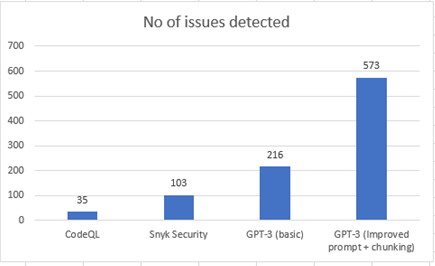

# **Challenges**

1. GPT (open source)
    1. Limit on Max tokens
    2. Rate limiting errors
2. Context on full compiled code cannot be fed to the model. So there is likely false positives
